<a href="https://colab.research.google.com/github/id2282/PFE/blob/main/deeper_random_forest_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score
import time
import requests
import io
from IPython.display import clear_output

# Import des bases de données

Lien de x_train : https://drive.google.com/file/d/1KbPm-NwHaqtwVP6rDjF2KWLhgk2K4jRm/view?usp=drive_link


Lien de y_train : https://drive.google.com/file/d/1IPIJWbSNkaNAbRfi-BBwPYR6r8iDv6kG/view?usp=drive_link

In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

ERROR: Operation cancelled by user


## On les prend à leur emplacement dans notre drive PFE

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import pandas as pd

# Authenticate and create the Drive API client
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Replace with your actual file IDs
file_id_x_train = "1KbPm-NwHaqtwVP6rDjF2KWLhgk2K4jRm"
file_id_y_train = "1IPIJWbSNkaNAbRfi-BBwPYR6r8iDv6kG"

# Function to read CSV file from Google Drive
def read_csv_from_drive(file_id):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    fh.seek(0)
    return pd.read_csv(fh)

# Read the content of x_train
df = read_csv_from_drive(file_id_x_train)

# Read the content of y_train
df_target = read_csv_from_drive(file_id_y_train)

# Metadata

## Structure des données
* Un jeu de données `x_train.csv` avec 667 265 lignes (i.e. 667 265 arrêts k, s, d) et 10 colonnes
* Un jeu de données `x_test.csv` avec 20 658 lignes (i.e. 20 658 arrêts k, s, d) et 12 colonnes
* Un jeu de données `y_train.csv` avec 667 265 lignes et une colonne, donnant la variable à prédire pour le jeu d’entraînement
* Un jeu de données `y_sample.csv` avec 20 658 lignes et une colonne dont les valeurs sont aléatoires entre [-10, 10]. Il s’agit d’un exemple de soumission que vous pouvez prendre en exemple pour préparer votre soumission

## Origine des données
Ces données sont issues d’applications métiers permettant d’obtenir les heures théoriques et observées d’arrivées et de départ des trains en gare.
Les données anonymisées sont structurées de la manière suivante, une observation est un arrêt de train (`cle_train`) à une gare (`cle_gare`) donnée pour un jour donné (`date`). La variable p0q0 est la différence entre le temps d’attente théorique et réalisé. S’il est négatif, cela signifie que le temps d’attente est plus long que prévu sinon cela signifie qu’il est plus court. La différence de temps d’attente est entière car par soucis de simplicité pour nos voyag.eurs.euses nous n’affichons que des minutes sur nos écrans.


Nous vous demandons de prédire la différence de temps d’attente à deux gares en temps réel. Nous introduisons p et q pour définir le passé : p définit les valeurs passées aux arrêts précédents pour le même train, q définit les valeurs passées pour le précédent train à la même gare.
La différence de temps d’attente observé est p0q0 qui est la différence de temps d’attente, noté Y(k,s,d), pour un arrêt, soit un train k à la gare s le jour d. Les colonnes, i.e., les variables explicatives, correspondent à 4 variables contextuelles et 6 valeurs passées :

## Variables contextuelles :
* `train` (k) : numéro de train (unique par jour)
* `gare` (s) : est l’identifiant de la gare
* `date` (d) : YYYY-MM-DD est la date du jour où le train roule
* `arret` : numéro de l’arrêt
Variables passées :
* `p2q0` : différence de temps d’attente du second train précèdent k-2 à la gare s
* `p3q0` : différence de temps d’attente du troisième train précèdent k-3 à la gare s
* `p4q0` : différence de temps d’attente du quatrième train précèdent k-4 à la gare s
* `p0q2` : différence de temps d’attente du même train k à la seconde gare précédente s-2
* `p0q3` : différence de temps d’attente du même train k à la troisième gare précédente s-3
* `p0q4` : différence de temps d’attente du même train k à la quatrième gare précédente s-4
Pour plus de détails sur la structure des données, je vous invite à consulter notre article de référence :

*One-Station-Ahead Forecasting of Dwell Time, Arrival Delay and Passenger Flows on Trains Equipped with Automatic Passenger Counting (APC) Device*.


# Filtrage de la base

### Data Loading and Preprocessing
On crée un évènement par ligne


In [ ]:
# Create a unique event identifier from train, date, gare, and arret
df['event_id'] = df.apply(lambda row: f"{row['train']}_{row['date']}_{row['gare']}_{row['arret']}", axis=1)
# Add target delay (p0q0); assumed to be in the same order as df
df['p0q0'] = df_target['p0q0']

In [ ]:
df.head()

Unnamed: 0.1  Unnamed: 0   train gare        date  arret  p2q0  p3q0  p4q0  \
0             0           0  VBXNMF  KYF  2023-04-03      8   0.0   0.0   1.0   
1             1           1  VBXNMF  JLR  2023-04-03      9   0.0   0.0   0.0   
2             2           2  VBXNMF  EOH  2023-04-03     10  -1.0   0.0   0.0   
3             3           3  VBXNMF  VXY  2023-04-03     11  -1.0  -1.0   0.0   
4             4           4  VBXNMF  OCB  2023-04-03     12  -1.0  -1.0  -1.0   

   p0q2  p0q3  p0q4                  event_id  p0q0  
0  -3.0  -1.0  -2.0   VBXNMF_2023-04-03_KYF_8  -1.0  
1   1.0   0.0   1.0   VBXNMF_2023-04-03_JLR_9  -1.0  
2  -1.0   0.0   0.0  VBXNMF_2023-04-03_EOH_10  -1.0  
3   2.0  -2.0   0.0  VBXNMF_2023-04-03_VXY_11   1.0  
4  -1.0   3.0   2.0  VBXNMF_2023-04-03_OCB_12   3.0

### **DEJA FAIT** Identifier des séquences de gare (ie des trajets ou extraits de trajets) qui se répètent dans la base de données.

In [ ]:
import pandas as pd
from collections import defaultdict

# Taille de la séquence à chercher
sequence_length = 20

# Stocker les séquences trouvées
sequence_counts = defaultdict(int)

# Parcourir les données avec une fenêtre glissante
for i in range(len(df) - sequence_length + 1):
    seq = tuple(df['gare'].iloc[i:i+sequence_length])  # Extraire la séquence
    sequence_counts[seq] += 1

# Filtrer et trier les séquences répétées par fréquence décroissante
repeated_sequences = {seq: count for seq, count in sequence_counts.items() if count > 10}
sorted_sequences = sorted(repeated_sequences.items(), key=lambda x: x[1], reverse=True)

# Afficher les séquences triées
for seq, count in sorted_sequences:
    print(f"Séquence: {seq} → Répétitions: {count}")


### On ne garde que les trajets (une séquence de gares)

Choisissons le trajet suivant :
('OCB', 'VXY', 'KCK', 'EOH', 'JLR', 'KYF', 'ZHN', 'BAP', 'RUP', 'JBZ', 'ZVY', 'AZA', 'XTD', 'GDU', 'OML', 'KOG', 'RLW', 'JUJ', 'ARX', 'CFK'). On filtre donc la base en conséquence :

La nouvelle base sera un enchaînement de la séquence décrite qqs lignes plus haut.

In [ ]:
import pandas as pd

# Séquence cible à rechercher
target_sequence = ('OCB', 'VXY', 'KCK', 'EOH', 'JLR', 'KYF', 'ZHN', 'BAP', 'RUP', 'JBZ', 'ZVY', 'AZA', 'XTD', 'GDU', 'OML', 'KOG', 'RLW', 'JUJ', 'ARX', 'CFK')
# Taille de la séquence
sequence_length = len(target_sequence)

# Trouver les indices correspondant à la séquence donnée
matched_indices = set()

for i in range(len(df) - sequence_length + 1):
    if tuple(df['gare'].iloc[i:i+sequence_length]) == target_sequence:
        matched_indices.update(range(i, i+sequence_length))

# Filtrer le DataFrame avec iloc (positions numériques)
df_filtered = df.iloc[sorted(matched_indices)].reset_index(drop=True)

print(df_filtered)

       Unnamed: 0.1  Unnamed: 0   train gare        date  arret  p2q0  p3q0  \
0             62373       62373  HUQCIG  OCB  2023-04-17      8  -1.0  -1.0   
1             62374       62374  HUQCIG  VXY  2023-04-17      9   0.0  -1.0   
2             62375       62375  HUQCIG  KCK  2023-04-17     10   1.0   0.0   
3             62376       62376  HUQCIG  EOH  2023-04-17     11   0.0   1.0   
4             62377       62377  HUQCIG  JLR  2023-04-17     12  -1.0   0.0   
...             ...         ...     ...  ...         ...    ...   ...   ...   
52715        666579      666579  CMFTNF  KOG  2023-11-10     27   1.0   3.0   
52716        666580      666580  CMFTNF  RLW  2023-11-10     28  -4.0   1.0   
52717        666581      666581  CMFTNF  JUJ  2023-11-10     29  -2.0  -4.0   
52718        666582      666582  CMFTNF  ARX  2023-11-10     30   3.0  -2.0   
52719        666583      666583  CMFTNF  CFK  2023-11-10     31   0.0   3.0   

       p4q0  p0q2  p0q3  p0q4                  even

On a 50000 observations, donc 2500 trajets.

## Données `train` et `test`
COnstruites à partir de `df_filtered`.

Dates uniques en listes

In [ ]:
indices_per_date = {}
for date, group in df_filtered.groupby('date'):
    indices_per_date[date] = group.index.tolist()

Define current vs. historical:
Les données historiques représentent la dernière date sur laquelle on va construire le réseau test.


In [ ]:
# - Historical data: all dates except the latest
# - Current (prediction) data: only the latest date
unique_dates = sorted(df_filtered['date'].unique())
current_date = unique_dates[-1]
historical_dates = unique_dates[:-1]

historical_indices = []
for date in historical_dates:
    historical_indices.extend(indices_per_date[date])
current_indices = indices_per_date[current_date]

historical_df = df_filtered.loc[historical_indices].copy()
current_df = df_filtered.loc[current_indices].copy()

historical_df.set_index('event_id', inplace=True)

print("Historical data shape:", historical_df.shape)
print("Current data shape:", current_df.shape)

Historical data shape: (52280, 13)
Current data shape: (440, 14)


Les données test comptent 52 trajets.

**L'idéal serait de les sélectionner aléatoirement ou d'en prendre un par jour dans** `df_filtered`.

On a donc :

- `historical_df` qui contient les données historiques qui vont nous servir à calibrer les modèes de régression locaux

- `current_df` contenant les trajets réalisés au dernier jour enregistré pour notre trajet d'intérêt. Nous allons mener la belief propagation et évaluer le modèle de réseaux bayésiens sur ces données.

## Build the directed acyclic graphs



In [ ]:
print(current_df)

       Unnamed: 0.1  Unnamed: 0   train gare        date  arret  p2q0  p3q0  \
52280        661485      661485  GZQIBW  OCB  2023-11-10      8   2.0   2.0   
52281        661486      661486  GZQIBW  VXY  2023-11-10      9   1.0   2.0   
52282        661487      661487  GZQIBW  KCK  2023-11-10     10   1.0   1.0   
52283        661488      661488  GZQIBW  EOH  2023-11-10     11   1.0   1.0   
52284        661489      661489  GZQIBW  JLR  2023-11-10     12  -1.0   1.0   
...             ...         ...     ...  ...         ...    ...   ...   ...   
52715        666579      666579  CMFTNF  KOG  2023-11-10     27   1.0   3.0   
52716        666580      666580  CMFTNF  RLW  2023-11-10     28  -4.0   1.0   
52717        666581      666581  CMFTNF  JUJ  2023-11-10     29  -2.0  -4.0   
52718        666582      666582  CMFTNF  ARX  2023-11-10     30   3.0  -2.0   
52719        666583      666583  CMFTNF  CFK  2023-11-10     31   0.0   3.0   

       p4q0  p0q2  p0q3  p0q4                  even

In [ ]:
current_df.head(20)

Unnamed: 0.1  Unnamed: 0   train gare        date  arret  p2q0  p3q0  \
52280        661485      661485  GZQIBW  OCB  2023-11-10      8   2.0   2.0   
52281        661486      661486  GZQIBW  VXY  2023-11-10      9   1.0   2.0   
52282        661487      661487  GZQIBW  KCK  2023-11-10     10   1.0   1.0   
52283        661488      661488  GZQIBW  EOH  2023-11-10     11   1.0   1.0   
52284        661489      661489  GZQIBW  JLR  2023-11-10     12  -1.0   1.0   
52285        661490      661490  GZQIBW  KYF  2023-11-10     13   0.0  -1.0   
52286        661491      661491  GZQIBW  ZHN  2023-11-10     14   1.0   0.0   
52287        661492      661492  GZQIBW  BAP  2023-11-10     15  -1.0   1.0   
52288        661493      661493  GZQIBW  RUP  2023-11-10     16  -1.0  -1.0   
52289        661494      661494  GZQIBW  JBZ  2023-11-10     17   0.0  -1.0   
52290        661495      661495  GZQIBW  ZVY  2023-11-10     18   1.0   0.0   
52291        661496      661496  GZQIBW  AZA  2023-11-10     19   1.0   1.0   
52292        661497      661497  GZQIBW  XTD  2023-11-10     20  -1.0   1.0   
52293        661498      661498  GZQIBW  GDU  2023-11-10     21   0.0  -1.0   
52294        661499      661499  GZQIBW  OML  2023-11-10     22   2.0   0.0   
52295        661500      661500  GZQIBW  KOG  2023-11-10     23   0.0   2.0   
52296        661501      661501  GZQIBW  RLW  2023-11-10     24  -3.0   0.0   
52297        661502      661502  GZQIBW  JUJ  2023-11-10     25  -2.0  -3.0   
52298        661503      661503  GZQIBW  ARX  2023-11-10     26   2.0  -2.0   
52299        661504      661504  GZQIBW  CFK  2023-11-10     27   0.0   2.0   

       p4q0  p0q2  p0q3  p0q4                  event_id  p0q0  
52280   2.0   0.0   0.0  -1.0   GZQIBW_2023-11-10_OCB_8   1.0  
52281   2.0   1.0   0.0  -1.0   GZQIBW_2023-11-10_VXY_9   1.0  
52282   2.0  -1.0   0.0  -1.0  GZQIBW_2023-11-10_KCK_10  -1.0  
52283   1.0   1.0  -1.0   1.0  GZQIBW_2023-11-10_EOH_11   0.0  
52284   1.0   0.0   0.0   1.0  GZQIBW_2023-11-10_JLR_12   1.0  
52285   1.0  -1.0  -1.0  -1.0  GZQIBW_2023-11-10_KYF_13  -1.0  
52286  -1.0  -1.0   0.0  -1.0  GZQIBW_2023-11-10_ZHN_14  -1.0  
52287   0.0   0.0   0.0   1.0  GZQIBW_2023-11-10_BAP_15   0.0  
52288   1.0   0.0   0.0   0.0  GZQIBW_2023-11-10_RUP_16   1.0  
52289  -1.0   0.0   0.0   1.0  GZQIBW_2023-11-10_JBZ_17   1.0  
52290  -1.0   1.0  -2.0   1.0  GZQIBW_2023-11-10_ZVY_18  -1.0  
52291   0.0   0.0   0.0   0.0  GZQIBW_2023-11-10_AZA_19   0.0  
52292   1.0   3.0   2.0   0.0  GZQIBW_2023-11-10_XTD_20   2.0  
52293   1.0   0.0   1.0   1.0  GZQIBW_2023-11-10_GDU_21   0.0  
52294  -1.0  -1.0  -2.0  -2.0  GZQIBW_2023-11-10_OML_22  -3.0  
52295   0.0   0.0  -2.0  -1.0  GZQIBW_2023-11-10_KOG_23  -2.0  
52296   2.0   3.0   2.0   1.0  GZQIBW_2023-11-10_RLW_24   2.0  
52297   0.0  -2.0   0.0  -1.0  GZQIBW_2023-11-10_JUJ_25   0.0  
52298  -3.0  -1.0  -2.0  -1.0  GZQIBW_2023-11-10_ARX_26  -1.0  
52299  -2.0   1.0   0.0   0.0  GZQIBW_2023-11-10_CFK_27   0.0

`piq0` : i-ième train prédédent à la gare s

`p0qj` : même train à la j-ième gare précédente

### Création de sous-dataframes pour chaque trajet de la base `current_df`

In [ ]:
# Création des sous-dataframes
n = 20  # Nombre de lignes par dataframe
num_splits = len(current_df) // n + (1 if len(current_df) % n != 0 else 0)  # Nombre total de dataframes

# Dictionnaire pour stocker les dataframes
dataframes = {f"test{i+1}": current_df.iloc[i*n:(i+1)*n] for i in range(num_splits)}

### On accède à un élément de `dataframes`

In [ ]:
print(dataframes["test20"])

       Unnamed: 0.1  Unnamed: 0   train gare        date  arret  p2q0  p3q0  \
52660        665832      665832  WIGKUR  OCB  2023-11-10      8  -4.0  -4.0   
52661        665833      665833  WIGKUR  VXY  2023-11-10      9  -1.0  -4.0   
52662        665834      665834  WIGKUR  KCK  2023-11-10     10  -2.0  -1.0   
52663        665835      665835  WIGKUR  EOH  2023-11-10     11   0.0  -2.0   
52664        665836      665836  WIGKUR  JLR  2023-11-10     12   0.0   0.0   
52665        665837      665837  WIGKUR  KYF  2023-11-10     13  -1.0   0.0   
52666        665838      665838  WIGKUR  ZHN  2023-11-10     14   0.0  -1.0   
52667        665839      665839  WIGKUR  BAP  2023-11-10     15   0.0   0.0   
52668        665840      665840  WIGKUR  RUP  2023-11-10     16  -1.0   0.0   
52669        665841      665841  WIGKUR  JBZ  2023-11-10     17   0.0  -1.0   
52670        665842      665842  WIGKUR  ZVY  2023-11-10     18   1.0   0.0   
52671        665843      665843  WIGKUR  AZA  2023-1

# Graphes et réseaux

Les **relations de causalité** se structurent comme cela dans nos graphes :
Nous ne nous basons que sur les variables $p_iq_0$ et $p_0q_j$ avec $i$ et $j$ différents de 0. en effet, la variable p0q0 n'est pas directement liée à ces variables ce qui ne permet pas d'attester de la **propriété de Markov locale**. Ensuite, aux coefficients de définir les influences des évènement les uns sur les autres.


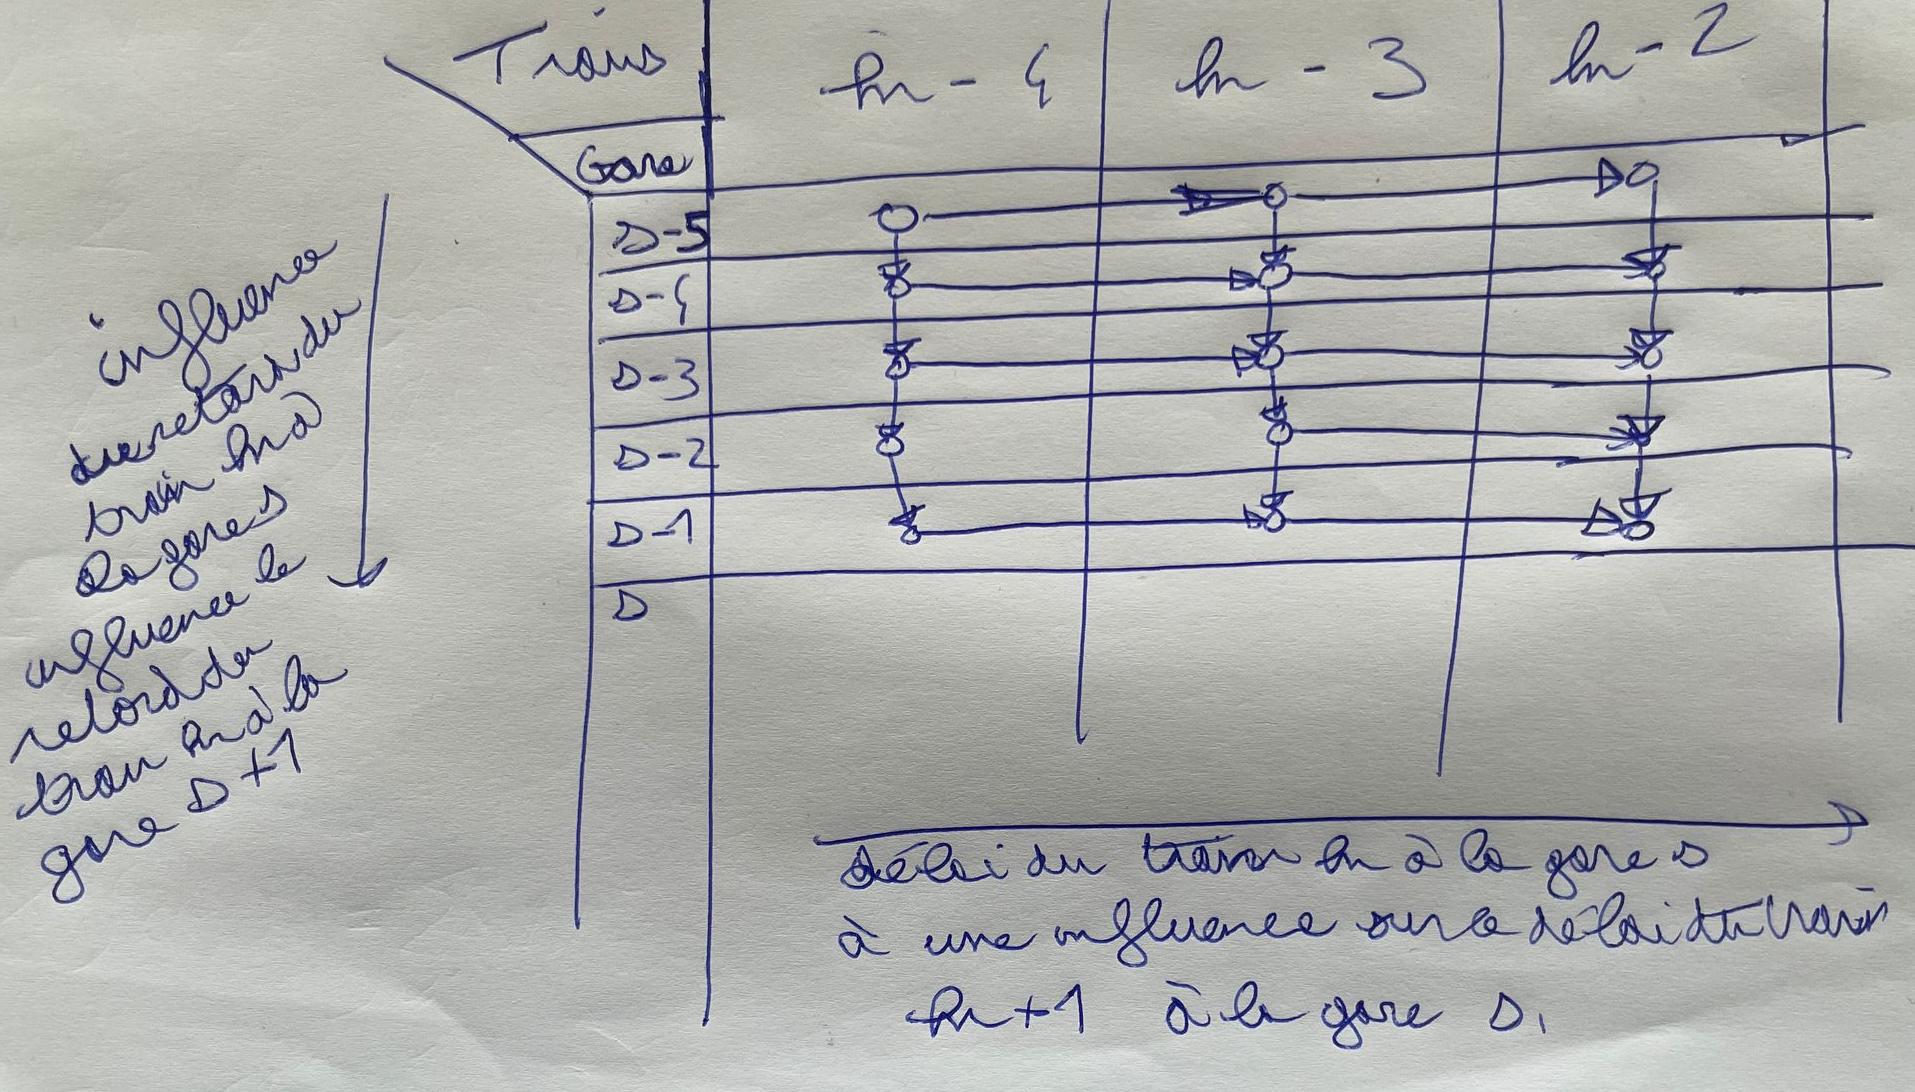

Transcrit à nos variables, cela donne : Les flèches correspondent aux arêtre de nos jeux de données

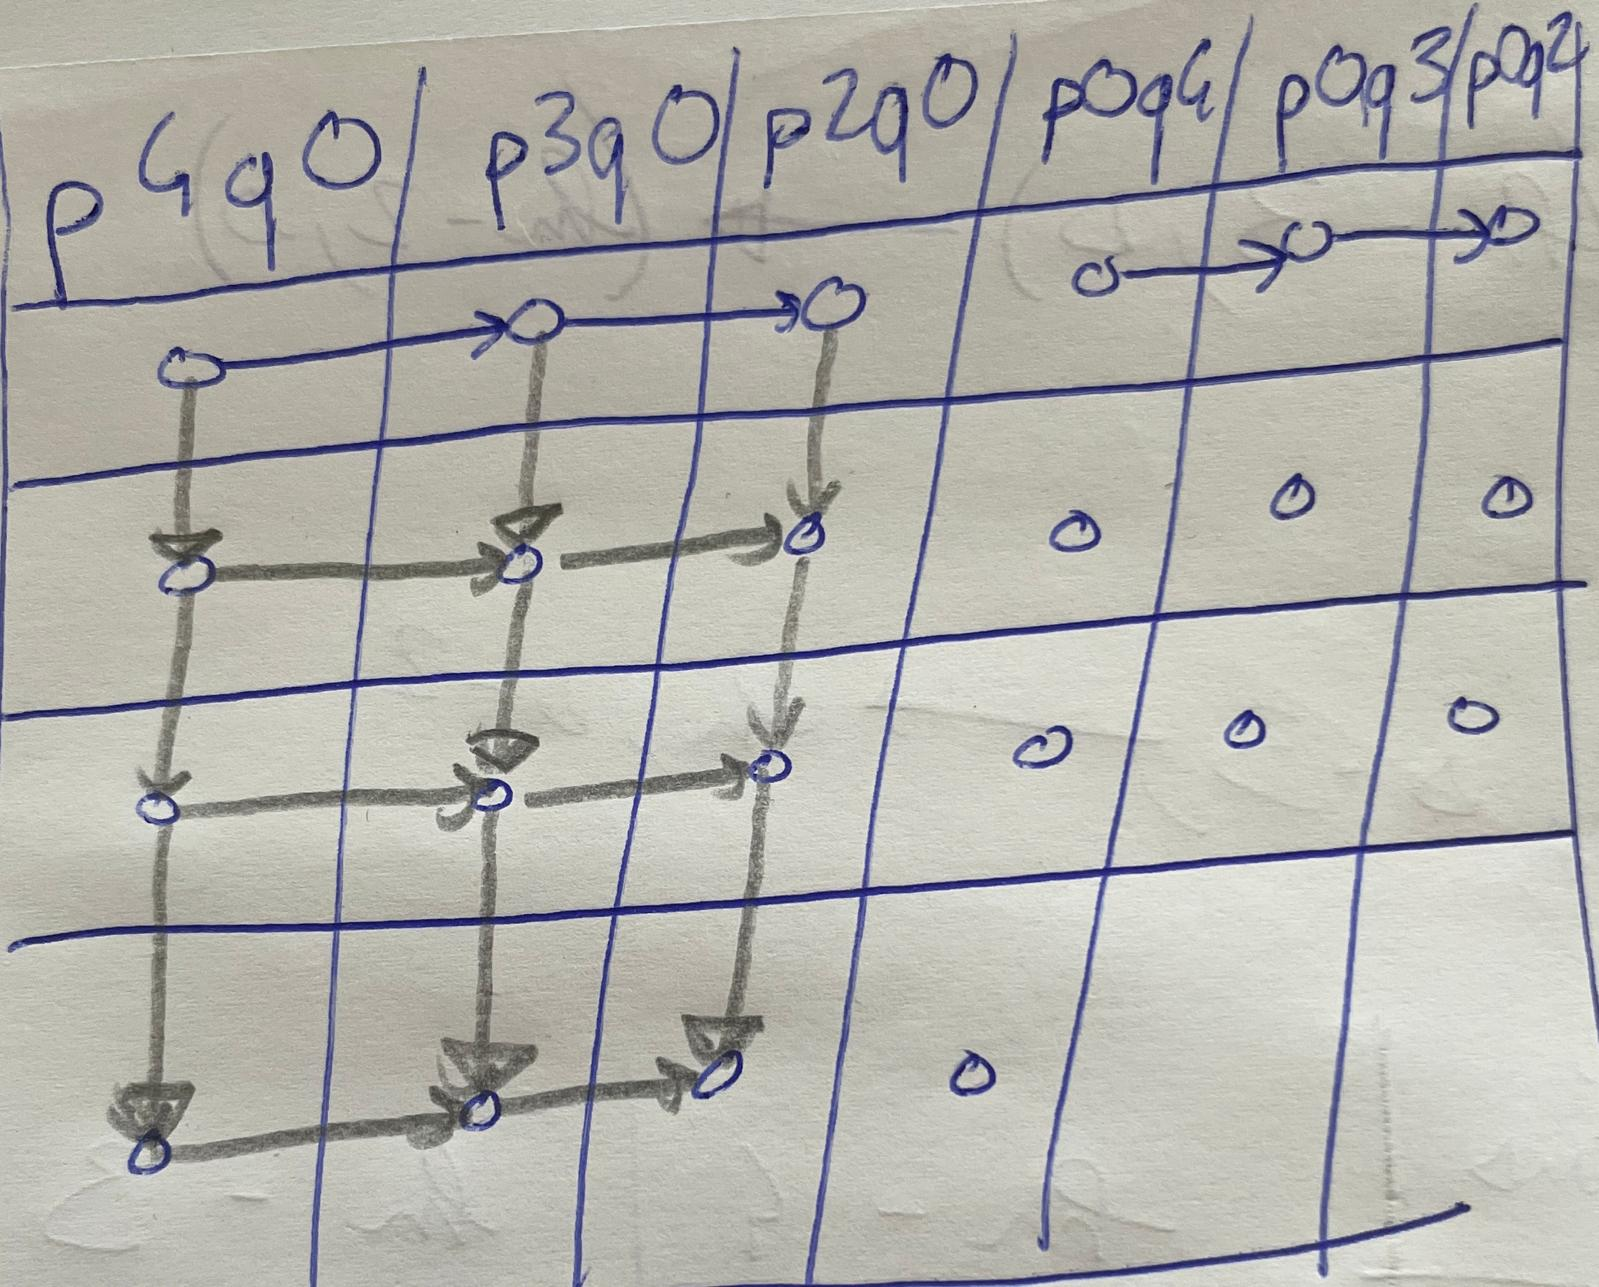

## Graphe sur lequel nous allons mener la belief propagation

Construit donc sur les données test `current_df`

In [ ]:
def creation_dag(data):
    """
    Crée un DAG en s'assurant que toutes les arêtes ne contiennent que des nœuds valides.
    """
    # Création du graphe orienté
    G = nx.DiGraph()

    # Liste des indices valides sous forme de chaînes (ex: "p4q0_0", "p3q0_1")
    valid_nodes = {f"{var}_{i}" for i in data.index for var in ["p4q0", "p3q0", "p2q0"]}

    # Ajout des arêtes intra-ligne (anciennes relations)
    for i in data.index:
        G.add_edge(f"p4q0_{i}", f"p3q0_{i}")
        G.add_edge(f"p3q0_{i}", f"p2q0_{i}")

    # Ajout des arêtes inter-lignes (anciennes relations)
    for i in data.index:
        if i + 1 in data.index:  # Vérifie si l'index suivant existe
            G.add_edge(f"p4q0_{i}", f"p4q0_{i+1}")
            G.add_edge(f"p3q0_{i}", f"p3q0_{i+1}")
            G.add_edge(f"p2q0_{i}", f"p2q0_{i+1}")

    # Ajout des nouvelles relations
    for i in data.index:
        if i - 2 in data.index:  # Vérifie si l'index i-2 existe
            G.add_edge(f"p4q0_{i-2}", f"p4q0_{i}")
            G.add_edge(f"p3q0_{i-2}", f"p3q0_{i}")
            G.add_edge(f"p2q0_{i-2}", f"p2q0_{i}")

        G.add_edge(f"p4q0_{i}", f"p2q0_{i}")

        if i + 1 in data.index:  # Vérifie si l'index suivant existe
            G.add_edge(f"p4q0_{i}", f"p3q0_{i+1}")
            G.add_edge(f"p3q0_{i}", f"p2q0_{i+1}")

    # Filtrer les arêtes invalides
    edges_to_remove = [(u, v) for u, v in G.edges if u not in valid_nodes or v not in valid_nodes]
    G.remove_edges_from(edges_to_remove)

    return G


In [ ]:
G = creation_dag(dataframes['test20'])

print(G.edges)

[('p4q0_52660', 'p3q0_52660'), ('p4q0_52660', 'p4q0_52661'), ('p4q0_52660', 'p2q0_52660'), ('p4q0_52660', 'p3q0_52661'), ('p4q0_52660', 'p4q0_52662'), ('p3q0_52660', 'p2q0_52660'), ('p3q0_52660', 'p3q0_52661'), ('p3q0_52660', 'p2q0_52661'), ('p3q0_52660', 'p3q0_52662'), ('p2q0_52660', 'p2q0_52661'), ('p2q0_52660', 'p2q0_52662'), ('p4q0_52661', 'p3q0_52661'), ('p4q0_52661', 'p4q0_52662'), ('p4q0_52661', 'p2q0_52661'), ('p4q0_52661', 'p3q0_52662'), ('p4q0_52661', 'p4q0_52663'), ('p3q0_52661', 'p2q0_52661'), ('p3q0_52661', 'p3q0_52662'), ('p3q0_52661', 'p2q0_52662'), ('p3q0_52661', 'p3q0_52663'), ('p2q0_52661', 'p2q0_52662'), ('p2q0_52661', 'p2q0_52663'), ('p4q0_52662', 'p3q0_52662'), ('p4q0_52662', 'p4q0_52663'), ('p4q0_52662', 'p2q0_52662'), ('p4q0_52662', 'p3q0_52663'), ('p4q0_52662', 'p4q0_52664'), ('p3q0_52662', 'p2q0_52662'), ('p3q0_52662', 'p3q0_52663'), ('p3q0_52662', 'p2q0_52663'), ('p3q0_52662', 'p3q0_52664'), ('p2q0_52662', 'p2q0_52663'), ('p2q0_52662', 'p2q0_52664'), ('p4q0_52

In [ ]:
# Dessin du graphe (optionnel)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G, seed=42)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Graphe Acyclique Orienté des Variables")
plt.show()

NameError: name 'G' is not defined

<Figure size 1200x600 with 0 Axes>

# 4. Calibrate Local Regression Models with Stratification (by train type)


La foncion suivante prend en argument les données historiques de trafic réalisées et ressort un dictionnaire dont chaque clé est une gare étant associée à au plus trois modèles de régression linéaires de type `statsmodels.api.sm`. Chaque couple variable/gare est associé à un modèle, sauf pour le couple `p4q0`/`OCB` qui correspond au premier noeud du graphe.




In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def train_models(historical_df):
    models = {}
    # Liste des gares uniques
    gares = historical_df["gare"].unique()

    for gare in gares:
        df_gare = historical_df[historical_df["gare"] == gare].copy()  # Filtrer par gare

        # Décalage des variables pour créer les variables explicatives
        df_gare["p4q0_prev"] = df_gare["p4q0"].shift(1)
        df_gare["p3q0_prev"] = df_gare["p3q0"].shift(1)
        df_gare["p2q0_prev"] = df_gare["p2q0"].shift(1)
        df_gare["p4q0_prev2"] = df_gare["p4q0"].shift(2)
        df_gare["p3q0_prev2"] = df_gare["p3q0"].shift(2)
        df_gare["p2q0_prev2"] = df_gare["p2q0"].shift(2)

        # Ajout des variables décalées pour les relations inter-lignes
        df_gare["p3q0_next"] = df_gare["p3q0"].shift(-1)
        df_gare["p2q0_next"] = df_gare["p2q0"].shift(-1)

        # Filtrer les valeurs NaN issues du décalage
        df_gare = df_gare.dropna()

        # Modèles de forêts aléatoires locaux
        models[gare] = {}

        if gare == "OCB":
            # p4q0[i] non modélisé
            X_p3 = df_gare[["p4q0"]]
            y_p3 = df_gare["p3q0"]
            model_p3 = RandomForestRegressor()
            model_p3.fit(X_p3, y_p3)

            X_p2 = df_gare[["p4q0","p3q0"]]
            y_p2 = df_gare["p2q0"]
            model_p2 = RandomForestRegressor()
            model_p2.fit(X_p2, y_p2)

            models[gare]["p3q0"] = model_p3
            models[gare]["p2q0"] = model_p2
        elif gare == 'VXY':
            # gare p4q0
            X_p4 = df_gare[["p4q0_prev"]]
            y_p4 = df_gare["p4q0"]
            model_p4 = RandomForestRegressor()
            model_p4.fit(X_p4, y_p4)

            # p3q0[i] ~ p3q0[i-1] + p4q0[i] + p4q0[i-1]
            X_p3 = df_gare[["p4q0_prev","p3q0_prev", "p4q0"]]
            y_p3 = df_gare["p3q0"]
            model_p3 = RandomForestRegressor()
            model_p3.fit(X_p3, y_p3)

            # p2q0[i] ~ p2q0[i-1] + p3q0[i] + p4q0[i]
            X_p2 = df_gare[["p3q0_prev","p2q0_prev", "p4q0","p3q0"]]
            y_p2 = df_gare["p2q0"]
            model_p2 = RandomForestRegressor()
            model_p2.fit(X_p2, y_p2)

            # Stockage des modèles pour cette gare
            models[gare]["p4q0"] = model_p4
            models[gare]["p3q0"] = model_p3
            models[gare]["p2q0"] = model_p2

        else:
            # p4q0[i] ~ p4q0[i-1] + p4q0[i-2]
            X_p4 = df_gare[["p4q0_prev2","p4q0_prev"]]
            y_p4 = df_gare["p4q0"]
            model_p4 = RandomForestRegressor()
            model_p4.fit(X_p4, y_p4)

            # p3q0[i] ~ p3q0[i-1] + p4q0[i] + p3q0[i-2] + p4q0[i-1]
            X_p3 = df_gare[["p3q0_prev2","p3q0_prev", "p4q0_prev", "p4q0"]]
            y_p3 = df_gare["p3q0"]
            model_p3 = RandomForestRegressor()
            model_p3.fit(X_p3, y_p3)

            # p2q0[i] ~ p2q0[i-1] + p3q0[i] + p2q0[i-2] + p4q0[i]
            X_p2 = df_gare[["p2q0_prev2", "p3q0_prev", "p2q0_prev", "p4q0", "p3q0"]]
            y_p2 = df_gare["p2q0"]
            model_p2 = RandomForestRegressor()
            model_p2.fit(X_p2, y_p2)

            # Stockage des modèles pour cette gare
            models[gare]["p4q0"] = model_p4
            models[gare]["p3q0"] = model_p3
            models[gare]["p2q0"] = model_p2

    return models

# Assuming historical_df is already defined
models = train_models(historical_df)

In [ ]:
# Affichage des importances (contributions) des caractéristiques des modèles par gare
for gare, model_dict in models.items():
    print(f"Modèles pour la gare {gare} :")
    for var, model in model_dict.items():
        print(f"  - Importance des caractéristiques pour {var} :")
        importances = model.feature_importances_
        feature_names = model.feature_names_in_ if hasattr(model, 'feature_names_in_') else model.feature_names_
        for feature_name, importance in zip(feature_names, importances):
            print(f"    - {feature_name}: {importance:.4f}")
        print()

Modèles pour la gare OCB :
  - Importance des caractéristiques pour p3q0 :
    - p4q0: 1.0000

  - Importance des caractéristiques pour p2q0 :
    - p4q0: 0.1533
    - p3q0: 0.8467

Modèles pour la gare VXY :
  - Importance des caractéristiques pour p4q0 :
    - p4q0_prev: 1.0000

  - Importance des caractéristiques pour p3q0 :
    - p4q0_prev: 0.0554
    - p3q0_prev: 0.0675
    - p4q0: 0.8772

  - Importance des caractéristiques pour p2q0 :
    - p3q0_prev: 0.1960
    - p2q0_prev: 0.1274
    - p4q0: 0.2362
    - p3q0: 0.4404

Modèles pour la gare KCK :
  - Importance des caractéristiques pour p4q0 :
    - p4q0_prev2: 0.4260
    - p4q0_prev: 0.5740

  - Importance des caractéristiques pour p3q0 :
    - p3q0_prev2: 0.1565
    - p3q0_prev: 0.1287
    - p4q0_prev: 0.2237
    - p4q0: 0.4911

  - Importance des caractéristiques pour p2q0 :
    - p2q0_prev2: 0.1284
    - p3q0_prev: 0.1170
    - p2q0_prev: 0.1861
    - p4q0: 0.1573
    - p3q0: 0.4112

Modèles pour la gare EOH :
  - Importance

### Etude de l'objet `models`

On vérifie la liste des gares qui doit correspondre au trajet d'intérêt.

In [ ]:
print(models.keys())  # Liste des gares

dict_keys(['OCB', 'VXY', 'KCK', 'EOH', 'JLR', 'KYF', 'ZHN', 'BAP', 'RUP', 'JBZ', 'ZVY', 'AZA', 'XTD', 'GDU', 'OML', 'KOG', 'RLW', 'JUJ', 'ARX', 'CFK'])


On essaye d'accéder aux éléments de l'objet `models`.

In [ ]:
model_ocb_p3q0 = models["KCK"]["p3q0"]

# Affichage de l'importance des caractéristiques pour le modèle du couple KCK/p3q0
importances = model_ocb_p3q0.feature_importances_
feature_names = model_ocb_p3q0.feature_names_in_ if hasattr(model_ocb_p3q0, 'feature_names_in_') else model_ocb_p3q0.feature_names_

print("Importance des caractéristiques pour le modèle KCK/p3q0 :")
for feature_name, importance in zip(feature_names, importances):
    print(f"  - {feature_name}: {importance:.4f}")

Importance des caractéristiques pour le modèle KCK/p3q0 :
  - p3q0_prev2: 0.1524
  - p3q0_prev: 0.1327
  - p4q0_prev: 0.2312
  - p4q0: 0.4837


# 5. Belief Propagation Using Local Regression Parameters


Pour un noeud à deux parents $X_1$ et $X_2$, la variance de l'estimation du noeud enfant est donnée par :
$$
\text{Var}(\hat{Y}) = \beta_1^2 \text{Var}(X_1) + \beta_2^2 \text{Var}(X_2) + 2\beta_1\beta_2 \text{Cov}(X_1, X_2)
$$

In [ ]:
import pandas as pd

def propagate_beliefs_random_forest(df, models):
    """
    Propage les croyances sur la base de données en utilisant les modèles appris et le DAG.
    """
    df = df.copy()  # Éviter de modifier l'original

    # Initialisation des colonnes de prédictions
    df["mean_p4q0"] = None
    df["mean_p3q0"] = None
    df["mean_p2q0"] = None
    df["mae_p4q0"] = None
    df["mae_p3q0"] = None
    df["mae_p2q0"] = None

    for i, row in df.iterrows():
        gare = row['gare']

        # Vérifier si la gare a un modèle associé
        if gare not in models:
            continue

        # Étape 1 : Prédiction de p4q0
        if 'p4q0' in models[gare]:
            model_p4q0 = models[gare]['p4q0']
            if i >= 2:
                df.at[i, 'mean_p4q0'] = model_p4q0.predict([[df.at[i-2, 'mean_p4q0'], df.at[i-1, 'mean_p4q0']]])[0]
                df.at[i, 'mae_p4q0'] = np.abs(df.at[i, 'mean_p4q0'] - df.at[i, 'p4q0'] )
            elif i == 1:
                df.at[i, 'mean_p4q0'] = model_p4q0.predict([[df.at[i-1, 'mean_p4q0'], row['p4q0']]])[0]
                df.at[i, 'mae_p4q0'] = np.abs(df.at[i, 'mean_p4q0'] - df.at[i, 'p4q0'] )
            else:
                df.at[i, 'mean_p4q0'] = row['p4q0']  # Valeur observée
                df.at[i, 'mae_p4q0'] = np.abs(df.at[i, 'mean_p4q0'] - df.at[i, 'p4q0'] )

        # Étape 2 : Prédiction de p3q0
        if 'p3q0' in models[gare]:
            model_p3q0 = models[gare]['p3q0']
            if i >= 2:
                df.at[i, 'mean_p3q0'] = model_p3q0.predict([[df.at[i-2, 'mean_p3q0'], df.at[i-1, 'mean_p4q0'],df.at[i-1, 'mean_p3q0'],
                                                              df.at[i, 'mean_p4q0']]])[0]
                df.at[i, 'mae_p3q0'] = np.abs(df.at[i, 'mean_p3q0'] - df.at[i, 'p3q0'] )
            elif i == 1:
                df.at[i, 'mean_p3q0'] = model_p3q0.predict([[df.at[i-1, 'mean_p4q0'], df.at[i-1, 'mean_p3q0'], df.at[i, 'mean_p4q0']]])[0]
                df.at[i, 'mae_p3q0'] = np.abs(df.at[i, 'mean_p3q0'] - df.at[i, 'p3q0'] )
            else:
                df.at[i, 'mean_p3q0'] = model_p3q0.predict([[df.at[i, 'mean_p4q0']]])[0]
                df.at[i, 'mae_p3q0'] = np.abs(df.at[i, 'mean_p3q0'] - df.at[i, 'p3q0'] )

        # Étape 3 : Prédiction de p2q0
        if 'p2q0' in models[gare]:
            model_p2q0 = models[gare]['p2q0']
            if i >= 2:
                df.at[i, 'mean_p2q0'] = model_p2q0.predict([[df.at[i-2, 'mean_p2q0'],
                                                              df.at[i-1, 'mean_p3q0'], df.at[i-1, 'mean_p2q0'],df.at[i, 'mean_p4q0'], df.at[i, 'mean_p3q0']]])[0]
                df.at[i, 'mae_p2q0'] = np.abs(df.at[i, 'mean_p2q0'] - df.at[i, 'p2q0'] )
            elif i == 1:
                df.at[i, 'mean_p2q0'] = model_p2q0.predict([[df.at[i-1, 'mean_p3q0'],df.at[i-1, 'mean_p2q0'], df.at[i, 'mean_p3q0']]])[0]
                df.at[i, 'mae_p2q0'] = np.abs(df.at[i, 'mean_p2q0'] - df.at[i, 'p2q0'] )
            else:
                df.at[i, 'mean_p2q0'] = model_p2q0.predict([[df.at[i, 'mean_p4q0'], df.at[i, 'mean_p3q0']]])[0]
                df.at[i, 'mae_p2q0'] = np.abs(df.at[i, 'mean_p2q0'] - df.at[i, 'p2q0'] )

    return df



# 6. Continuous Data Arrival & Dynamic Graph Updates


Dans un premier temps, nous implémentons une fonction qui prend en argument les paramètres d'une loi normale, la taille de l'échantillon à générer et qui renvoie le maximum à posteriori de l'échantillon simulé.

La fonction suivante prend en argument une base de données (comprenant la réalisation d'un trajet de train), un réseau bayésien associé à ces données, une "variable de départ" entre `p4q0`, `p3q0` et `p2q0` et une gare de départ permettent d'identifier le noeud de départ à partir duquel on étend la belief propagation. Le paramètree horizon indique à quel horizon on veut prédire les noeuds suivants dans l'ordre topologique.

Petite fonction utile pour déterminer si l'horizon demndé est possible.

In [ ]:
def remove_until_value(lst, val):
    if val in lst:
        return lst[lst.index(val):]  # Coupe à partir de la première occurrence de `val`
    return []  # Retourne une liste vide si `val` n'est pas trouvée

In [ ]:
G1

In [ ]:
import numpy as np
import networkx as nx

def update_estimations_from_node(df, models, G, start_variable, start_gare, horizon):
    """
    Met à jour les estimations en partant d'un nœud donné et en avançant sur un horizon défini.

    Arguments :
    - df : DataFrame contenant les données
    - models : dictionnaire des modèles de régression
    - G : graphe orienté des dépendances entre variables
    - start_variable : nom de la variable de départ (ex: "p3q0")
    - start_gare : nom de la gare de départ (ex: "Gare A")
    - horizon : nombre de nœuds à prédire après le point de départ
    """
    df = df.copy()  # Éviter de modifier l'original

    # On initialise LES COLONNES mean
    for col in ['p2q0', 'p3q0', 'p4q0']:  # Add other relevant columns if needed
        if f'mean_{col}' not in df.columns:
            df[f'mean_{col}'] = df[col]  # Initialize with actual values

    # Trouver l'index correspondant à la gare donnée
    start_idx = df.index[df['gare'] == start_gare].tolist()
    if not start_idx:
        raise ValueError(f"Gare '{start_gare}' non trouvée dans le DataFrame.")
    start_idx = start_idx[0]  # On prend le premier match

    # Déterminer le nœud de départ
    start_node = f"{start_variable}_{start_idx}"

    # Obtenir l'ordre topologique du graphe sous forme de liste
    topological_order = list(nx.topological_sort(G))

    # Trouver la position du nœud de départ dans l'ordre topologique
    start_pos = topological_order.index(start_node)

    # On initialise le MAE à zéro
    mae = 0

    if len(topological_order) < start_pos + horizon + 1:
        raise ValueError("horizon trop lointain (non atteignable)")
    else:
        # Identifier les nœuds à mettre à jour (ceux après start_node)
        nodes_to_update = topological_order[start_pos:start_pos + horizon + 1]  # +1 pour inclure start_node

        # Mise à jour des estimations
        for node in nodes_to_update:
            var_name, idx = node.split("_")
            idx = int(idx)
            #print(idx)
            gare = df.at[idx, 'gare']

            # Si le nœud est avant le point de départ dans l'ordre topologique, on prend la valeur réelle
            if node not in nodes_to_update:
                df.at[idx, f"mean_{var_name}"] = df.at[idx, var_name]
                continue  # On passe au suivant

            # Sinon, on prédit en utilisant les modèles
            if var_name == "p4q0":
                if idx > 1 and gare != "OCB":
                    model = models[gare]['p4q0']
                    df.at[idx, 'mean_p4q0'] = model.predict([[df.at[idx-2, 'mean_p4q0'], df.at[idx-1, 'mean_p4q0']]])[0]
                    mae = np.abs(df.at[idx, var_name] - df.at[idx, 'mean_p4q0'])
                elif idx == 1:
                    model = models[gare]['p4q0']
                    df.at[idx, 'mean_p4q0'] = model.predict([[df.at[idx-1, 'mean_p4q0'], df.at[idx, 'mean_p4q0']]])[0]
                else:
                    df.at[idx, 'mean_p4q0'] = df.at[idx, 'p4q0']
            elif var_name == "p3q0":
                model = models[gare]['p3q0']
                if idx > 1:
                    df.at[idx, 'mean_p3q0'] = model.predict([[df.at[idx-2, 'mean_p3q0'], df.at[idx-1, 'mean_p4q0'], df.at[idx-1, 'mean_p3q0'], df.at[idx, 'mean_p4q0']]])[0]
                elif idx == 1:
                    df.at[idx, 'mean_p3q0'] = model.predict([[df.at[idx-1, 'mean_p4q0'], df.at[idx-1, 'mean_p3q0'], df.at[idx, 'mean_p4q0']]])[0]
                else:
                    df.at[idx, 'mean_p3q0'] = model.predict([[df.at[idx, 'mean_p4q0']]])[0]
                mae = np.abs(df.at[idx, var_name] - df.at[idx, 'mean_p3q0'])

            elif var_name == "p2q0":
                model = models[gare]['p2q0']
                if idx > 1:
                    df.at[idx, 'mean_p2q0'] = model.predict([[df.at[idx-2, 'mean_p2q0'], df.at[idx-1, 'mean_p3q0'], df.at[idx-1, 'mean_p2q0'], df.at[idx, 'mean_p4q0'], df.at[idx, 'mean_p3q0']]])[0]
                elif idx == 1:
                    df.at[idx, 'mean_p2q0'] = model.predict([[df.at[idx-1, 'mean_p3q0'], df.at[idx-1, 'mean_p2q0'], df.at[idx, 'mean_p3q0']]])[0]
                else:
                    df.at[idx, 'mean_p2q0'] = model.predict([[df.at[idx, 'mean_p4q0'], df.at[idx, 'mean_p3q0']]])[0]
                mae = np.abs(df.at[idx, var_name] - df.at[idx, 'mean_p2q0'])

    return df, mae  # Retourne le dernier mae enregistré


#### **Définir G1 si on veut exécuter les deux prochaines cellules**

In [ ]:
G1 = creation_dag(dataframes['test3'])

In [ ]:
print(list(nx.topological_sort(G1)))

['p4q0_52320', 'p3q0_52320', 'p4q0_52321', 'p2q0_52320', 'p3q0_52321', 'p4q0_52322', 'p2q0_52321', 'p3q0_52322', 'p4q0_52323', 'p2q0_52322', 'p3q0_52323', 'p4q0_52324', 'p2q0_52323', 'p3q0_52324', 'p4q0_52325', 'p2q0_52324', 'p3q0_52325', 'p4q0_52326', 'p2q0_52325', 'p3q0_52326', 'p4q0_52327', 'p2q0_52326', 'p3q0_52327', 'p4q0_52328', 'p2q0_52327', 'p3q0_52328', 'p4q0_52329', 'p2q0_52328', 'p3q0_52329', 'p4q0_52330', 'p2q0_52329', 'p3q0_52330', 'p4q0_52331', 'p2q0_52330', 'p3q0_52331', 'p4q0_52332', 'p2q0_52331', 'p3q0_52332', 'p4q0_52333', 'p2q0_52332', 'p3q0_52333', 'p4q0_52334', 'p2q0_52333', 'p3q0_52334', 'p4q0_52335', 'p2q0_52334', 'p3q0_52335', 'p4q0_52336', 'p2q0_52335', 'p3q0_52336', 'p4q0_52337', 'p2q0_52336', 'p3q0_52337', 'p4q0_52338', 'p2q0_52337', 'p3q0_52338', 'p4q0_52339', 'p2q0_52338', 'p3q0_52339', 'p2q0_52339']


In [ ]:
df_updated, mae = update_estimations_from_node(dataframes['test3'], models, G1, "p3q0", "JLR", 40)

52324
52324
52325
52325
52325
52326
52326
52326
52327
52327
52327
52328
52328
52328
52329
52329
52329
52330
52330
52330
52331


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

52331
52331
52332
52332
52332
52333
52333
52333
52334
52334
52334
52335
52335
52335
52336
52336
52336
52337
52337
52337


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

In [ ]:
print(mae)



0.5844515913223343


# Evaluation de la simulation

Dans cette partie, nous voulons implémenter une fonction `evaluate_prediction_mae` permettant, pour chaque horizon de prédiction en termes de noeuds dans l'ordre topologique, d'estimer l'écart moyen entre la prédiction du retard et le temps d'attente réel observé.

In [ ]:
import numpy as np

liste_gares = ('OCB', 'VXY', 'KCK', 'EOH', 'JLR', 'KYF', 'ZHN', 'BAP', 'RUP', 'JBZ', 'ZVY', 'AZA', 'XTD', 'GDU', 'OML', 'KOG', 'RLW', 'JUJ', 'ARX', 'CFK')

def evaluate_prediction_mae(df, models, G, horizon):
    """
    Évalue la performance des prédictions en calculant le MAE moyen pour toutes les variables
    ('p2q0', 'p3q0', 'p4q0') et tous les points de départ possibles.

    Arguments :
    - df : DataFrame contenant les données (index générique)
    - models : dictionnaire des modèles de régression
    - G : graphe orienté des dépendances entre variables
    - horizon : nombre de nœuds à prédire après le point de départ

    Retourne :
    - MAE moyen sur toutes les variables et tous les points de départ possibles
    """

    # Obtenir l'ordre topologique du graphe sous forme de liste
    topological_order = list(nx.topological_sort(G))

    length = len(topological_order)

    mae_values = []

    #gares_a_parcourir = remove_until_value(liste_gares, )

    for node in topological_order[7: length-horizon-1]:
      #On récupère la variable associée au noeud
      var = node[:4]
      # ON récupère le numéro de ligne (index) asssocié au noeud d'intérêt
      ligne = node[-5:]
      ligne = int(ligne)
      #On récupère la gare associée au numéro de ligne (index) dans le dataframe d'entrée
      gare = df.loc[ligne, 'gare']
      # On fait tourner la fonction update_estimations_from_node en partant du couple gare/variable (noeud) d'intérêt
      df_pred, mae =  update_estimations_from_node(df, models, G, var, gare, horizon)

      # On ajoute le mae qui nous intéresse à la liste des mae dont on veut computer la moyenne pour un horizon donné
      mae_values.append(mae)

    #On retourne le MAE moyen pour l'horizon prédéfini
    return np.mean(mae_values)

### QQs exemples

In [ ]:
G.edges

In [ ]:
G = creation_dag(dataframes['test20'])

In [ ]:
mae_10 = evaluate_prediction_mae(dataframes['test20'], models, G=G, horizon = 30)

clear_output(wait = True)

In [ ]:
mae_10

0.5594359452992221

# Généralisation de la prédiction avec une grande boucle sur toutes les bases test

In [ ]:
test_list = [f'test{i}' for i in range(1, 23)]
test_list

['test1',
 'test2',
 'test3',
 'test4',
 'test5',
 'test6',
 'test7',
 'test8',
 'test9',
 'test10',
 'test11',
 'test12',
 'test13',
 'test14',
 'test15',
 'test16',
 'test17',
 'test18',
 'test19',
 'test20',
 'test21',
 'test22']

### Pour chaque horizon, on calcule le mae moyen sur une base test.

In [ ]:
meanabsoluteerrors = []
horiz_mae = {}

for horizon in range(1,60):
  mae_list =  []
  mae = evaluate_prediction_mae(dataframes['test20'], models, G=G, horizon = horizon)
  mae_list.append(mae)
  horiz_mae[f'{horizon}'] = np.mean(mae_list)

In [ ]:
horiz_mae

{'1': 0.7300730608648469,
 '2': 0.7469906131821392,
 '3': 0.6938004831778122,
 '4': 0.6524358193051457,
 '5': 0.673916403420821,
 '6': 0.7101816253483938,
 '7': 0.6742458230443015,
 '8': 0.5625022696473947,
 '9': 0.5486983627292245,
 '10': 0.6392594920756431,
 '11': 0.6683929277511472,
 '12': 0.6624540815001205,
 '13': 0.5938810297431227,
 '14': 0.5571593998250779,
 '15': 0.5508172742127656,
 '16': 0.5245227373160227,
 '17': 0.5730155516202512,
 '18': 0.584172399664239,
 '19': 0.568102893535703,
 '20': 0.5757175666727818,
 '21': 0.5729379563903038,
 '22': 0.5929714583320889,
 '23': 0.6132587846562232,
 '24': 0.6198135025856921,
 '25': 0.6303758889727935,
 '26': 0.6400217067076721,
 '27': 0.6471408052132817,
 '28': 0.606717108605105,
 '29': 0.5852347965388004,
 '30': 0.5594359452992221,
 '31': 0.5229487680912486,
 '32': 0.5165378251600394,
 '33': 0.5189871843789888,
 '34': 0.49604836026151017,
 '35': 0.4786165646041327,
 '36': 0.47853798803276565,
 '37': 0.48467235123825014,
 '38': 0.50

###Grande boucle sur toutes les données test

### Pour chaque horizon, on calcule le mae moyen sur toutes les bases test.

In [ ]:
meanabsoluteerrors = []
horiz_mae = {}

for horizon in range(1,60):
  mae_list =  []
  for base in test_list:
    G = creation_dag(dataframes[base])
    mae = evaluate_prediction_mae(dataframes[base], models, G=G, horizon = horizon)
    mae_list.append(mae)
  horiz_mae[f'{horizon}'] = np.mean(mae_list)

In [ ]:
horiz_mae

{'1': 0.7728691402243322,
 '2': 0.8445237376834548,
 '3': 0.8632260400022033,
 '4': 0.8708509489244228,
 '5': 0.8744293763921682,
 '6': 0.8126540914568345,
 '7': 0.8258546146696937,
 '8': 0.8352343762676632,
 '9': 0.7918791195040344,
 '10': 0.7902254205201367,
 '11': 0.8222351432837562,
 '12': 0.8337692520550103,
 '13': 0.804813384977405,
 '14': 0.8022992829897132,
 '15': 0.8194870562365193,
 '16': 0.8032486613754027,
 '17': 0.8017995490762861,
 '18': 0.791634721875014,
 '19': 0.7935728943460311,
 '20': 0.7829969088726579,
 '21': 0.7751903847026338,
 '22': 0.7716498429975868,
 '23': 0.7822712455126237,
 '24': 0.7956473354678244,
 '25': 0.8128255715482225,
 '26': 0.8316691039142122,
 '27': 0.8380688143663231,
 '28': 0.8140981338573138,
 '29': 0.8073603279163017,
 '30': 0.7798984140891637,
 '31': 0.7536787729717105,
 '32': 0.75778216889852,
 '33': 0.7234275735500484,
 '34': 0.6895576810402685,
 '35': 0.6577514689208608,
 '36': 0.6686961789170988,
 '37': 0.67922588836451,
 '38': 0.6995891

### Pour chaque horizon, on stocke les mae associés pour chaque base test.

In [ ]:
meanabsoluteerrors = []
horiz_mae_list = {}

for horizon in range(1,60):
  mae_list =  []
  for base in test_list:
    G = creation_dag(dataframes[base])
    mae = evaluate_prediction_mae(dataframes[base], models, G=G, horizon = horizon)
    mae_list.append(mae)
  horiz_mae_list[f'{horizon}'] = mae_list

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Random

#### Instanciation de l'objet des mae pour chaque horizons

In [ ]:
horiz_mae_list = {'1': [0.615093604801409,
  0.8277234897715618,
  0.6567680535275724,
  0.917091145433702,
  0.8571818972090005,
  0.5402637745019235,
  0.852368046624954,
  0.7478214657177895,
  0.7502671219977808,
  0.6148900498709994,
  1.033178270395533,
  0.5613388485784294,
  0.5830214916974388,
  0.6501973975505874,
  1.6774237561312062,
  0.4486493210291711,
  0.8485098872542983,
  0.7562386990631378,
  0.5259707298992958,
  0.7141927162150572,
  0.8770409612215283,
  0.9359193786765023],
 '2': [0.7784196633901278,
  0.787603925144665,
  0.7003393662416899,
  0.9375871081157656,
  0.9327760109052362,
  0.6110652631608761,
  0.8548560245033098,
  0.7928409279561471,
  0.8466767121741499,
  0.7833371463473253,
  1.204546127084476,
  0.7244355616570747,
  0.5946295415141228,
  0.8038027842915793,
  1.981064531726943,
  0.5135748859658079,
  0.8540403134964982,
  0.7845373538933248,
  0.5917388885240455,
  0.7310510809016465,
  0.7834115112245993,
  0.8959981767667733],
 '3': [0.7721989961467842,
  0.8362896241710187,
  0.6908545219451487,
  0.9505859125845533,
  1.088947769572147,
  0.611262422972823,
  0.8245504778939644,
  0.9175966757258674,
  0.9598818506922815,
  0.8209699569661426,
  1.1760234309766344,
  0.7252599627952074,
  0.606937255360559,
  0.8038425082208595,
  1.8681389776601889,
  0.5321268650139283,
  0.7773961743488126,
  0.7670882388842525,
  0.5910095885057026,
  0.6726979799792572,
  0.8044051641615357,
  1.008051866789762],
 '4': [0.8536176509691401,
  0.7502424766686677,
  0.621541693741282,
  0.9550424074092803,
  1.0350017406590888,
  0.6723365420405751,
  0.9127473554974809,
  0.961751896162264,
  1.0157542122743304,
  0.8180186812086822,
  1.1753789789926659,
  0.7610936203920833,
  0.6814273864589643,
  0.8021275382918808,
  1.716359603508866,
  0.6109654407964946,
  0.7585829318151109,
  0.7214150218210281,
  0.6743886253739085,
  0.6543991071651606,
  0.6919337463412191,
  1.086363161151127],
 '5': [0.782672109039728,
  0.7765117958131013,
  0.6461456771468591,
  1.062268872438271,
  1.0042219273982844,
  0.7260679793852699,
  0.9755770647243786,
  0.9526377915511626,
  1.0757167310915674,
  0.8010979276996449,
  1.1409152964832967,
  0.7275127930693487,
  0.6814453944270261,
  0.7988024446160564,
  1.567147741285074,
  0.5718516474911495,
  0.7079554320502393,
  0.7307187234211132,
  0.6858232985342061,
  0.6854910468450859,
  0.7036573543103499,
  1.2007614999196736],
 '6': [0.6444415679279332,
  0.7982181320302293,
  0.6253339325274618,
  0.9136732352193896,
  0.997044509549775,
  0.624676004911494,
  0.9982482719030297,
  0.9410078126150528,
  1.1418639556165322,
  0.7893920750614162,
  1.050721935970025,
  0.7021204386502503,
  0.5640963077585847,
  0.7804064510642843,
  1.4912327960926688,
  0.4972133164143741,
  0.6596715543621802,
  0.7308950931956807,
  0.5730584838456033,
  0.737046289123332,
  0.6994810543427867,
  1.0703472456877252],
 '7': [0.6009115626627021,
  0.7795548333118693,
  0.6332105177066251,
  0.8959624995601857,
  0.9821868701126142,
  0.6092638476959684,
  0.9781141113552446,
  0.9347671607413529,
  1.0900795945654793,
  0.784845682928642,
  1.107247391555753,
  0.7565929568303026,
  0.5473379350507723,
  0.8589591029493776,
  1.2727507555903876,
  0.5215352179552151,
  0.7688584568542274,
  0.7502957684613645,
  0.5564992706063913,
  0.6613454580182988,
  0.723040279655354,
  1.1057707168741662],
 '8': [0.6291818309742048,
  0.8547938459850389,
  0.6969241264059224,
  0.9578929966406545,
  0.9458496501874127,
  0.7187812098826282,
  1.0074736381571425,
  0.887168382669411,
  1.0903348335324576,
  0.8506239162888672,
  1.0820623228051445,
  0.7739074208094,
  0.661502444175441,
  0.8503423598987919,
  1.0954218997931204,
  0.5786034801456584,
  0.7663363929956759,
  0.7992150905080266,
  0.6632319674583858,
  0.6765173659597955,
  0.7886208480245948,
  1.1479897385650908],
 '9': [0.5776770874370376,
  0.7278274353617065,
  0.6406029939372204,
  0.8821474252753494,
  0.921381447782677,
  0.6793865993175241,
  0.9308888374123676,
  0.8124831216393388,
  1.000454332766374,
  0.7683433824508603,
  1.089609298754271,
  0.6772495666942344,
  0.6149267821733433,
  0.7526303465449006,
  1.0802120309973249,
  0.5221539653678706,
  0.7418428139502158,
  0.7043397230043221,
  0.6225455140462063,
  0.6770211302625674,
  0.6751264131043636,
  1.0779271664009087],
 '10': [0.5568422718707112,
  0.7050909909614704,
  0.6220627058276419,
  0.8756897917991028,
  0.8676164931124223,
  0.6327862171382674,
  0.9191979000554751,
  0.7852472122452993,
  0.9471277129341253,
  0.7246515719011176,
  1.07504086999558,
  0.6731501993193495,
  0.5675305028279036,
  0.7618822246530409,
  0.9733761488850406,
  0.499593038990218,
  0.774663255542771,
  0.7216139448951767,
  0.574591772693823,
  0.6272333709715339,
  0.7031075905345922,
  1.0510688969458837],
 '11': [0.6317679978842655,
  0.7138499680308831,
  0.6265538941974409,
  0.9019354362664199,
  0.940363224961032,
  0.6231820630569305,
  0.8613280241901018,
  0.8699659825857602,
  1.070901708819277,
  0.8085095134475411,
  1.1501615938881393,
  0.7809661805357053,
  0.5998797438069212,
  0.8270649198570402,
  1.1075038784216575,
  0.5356262981392232,
  0.8565597108704446,
  0.7164980271060953,
  0.5993922837305657,
  0.6726520870505251,
  0.6792088209040804,
  1.1103546018942063],
 '12': [0.6610046628495584,
  0.6875390382788755,
  0.6788869717907572,
  0.895130335847082,
  0.9557175689436482,
  0.6425267405934219,
  0.8284776723716831,
  0.8182734702619763,
  0.9880895596161974,
  0.7816858985203492,
  1.1730018557217075,
  0.7061508766963998,
  0.6211146374188188,
  0.7734754693883716,
  1.0627362779576193,
  0.5398037184065269,
  0.8392107838822284,
  0.6948636980054019,
  0.6228642405934218,
  0.629523873366831,
  0.6204806549747923,
  1.0836013959255528],
 '13': [0.5954461730055071,
  0.7458392916118263,
  0.6461160277419373,
  0.8550464989553637,
  1.011344947393168,
  0.6373536127913088,
  0.9098064313504003,
  0.7827759520278996,
  0.9380551115000147,
  0.7574765484421542,
  1.113697511171566,
  0.6149812106544754,
  0.6155206864583823,
  0.7350149809368397,
  1.119497270982977,
  0.4719849562607395,
  0.8054886509497522,
  0.6983433103387215,
  0.6173151512528472,
  0.5549190752326101,
  0.6009794029337305,
  1.0415096831046076],
 '14': [0.6660147403331091,
  0.7039956359615609,
  0.6681375084380463,
  0.8539896301903978,
  0.9067660318561491,
  0.670291657065033,
  0.9498238469648148,
  0.8223026988554201,
  0.8693123238136006,
  0.7189688822807672,
  1.1091713676216093,
  0.6749276044119386,
  0.6494631274075559,
  0.75793281476439,
  1.221937071038836,
  0.5168368417970781,
  0.8158348798025985,
  0.7321310841524987,
  0.6497258675913488,
  0.5181930244191323,
  0.6023034704284773,
  0.9973545925914488],
 '15': [0.6658156882507817,
  0.6960860824824321,
  0.7239459901835964,
  0.8626382228087858,
  0.8472473180763241,
  0.6808736663745604,
  0.952065239813142,
  0.8154848642928565,
  0.8552398533805867,
  0.67691767703046,
  1.0603672825074464,
  0.652719175485657,
  0.6594822034830974,
  0.7317879735605463,
  1.26701301246653,
  0.5263613218375021,
  0.7818835738270116,
  0.7426056175254547,
  0.6597520447529387,
  0.5105099191070028,
  0.6553284538452445,
  0.9967720921373776],
 '16': [0.6930983189962265,
  0.6704495530348002,
  0.6898670098656388,
  0.8421906014558984,
  0.9069941136203893,
  0.6726891205156446,
  0.8719353444706548,
  0.7375128600111504,
  0.6884749943469962,
  0.6853988997918098,
  1.1138437802939143,
  0.6440282176485401,
  0.650703450321641,
  0.7066250740226018,
  1.2327496659640969,
  0.5147580528438989,
  0.7583892847440824,
  0.7385889632169952,
  0.6509807871823112,
  0.5298944810727946,
  0.6195157604929017,
  0.9032545049991799],
 '17': [0.6430926330296405,
  0.667711664913785,
  0.711218152904835,
  0.8197344354799901,
  0.8349697928658552,
  0.6857191858932646,
  0.9074730489672481,
  0.7591740901970463,
  0.6896393647966417,
  0.6277017226143916,
  1.1696952752231706,
  0.6605951673011259,
  0.6631053536937183,
  0.7033242845719109,
  1.0921695393443314,
  0.5259743727173378,
  0.7987349956678185,
  0.7520733098146539,
  0.6633906144646932,
  0.5753518133258678,
  0.6388568678357341,
  0.9111700726412552],
 '18': [0.6276702899736863,
  0.6646981798374533,
  0.6746668769070833,
  0.8054296258461481,
  0.756238643335133,
  0.6811780407469934,
  0.919050767102083,
  0.7561532889799039,
  0.6872050914596582,
  0.5559221732913223,
  1.0991547601424045,
  0.6459183750162306,
  0.6578990958356954,
  0.6923509299254065,
  1.1446538704278009,
  0.5181242135559776,
  0.7558392297573515,
  0.7505904085196817,
  0.6581927466293462,
  0.5859107021493353,
  0.6009051912757863,
  0.9043488156897685],
 '19': [0.5811447454173917,
  0.6440590031549771,
  0.6712274889987692,
  0.7599846416617204,
  0.7214016336069871,
  0.7068611404982991,
  0.9030881838122797,
  0.7452558903106283,
  0.706228200484135,
  0.5801874009823376,
  1.004243019270102,
  0.6705414809140661,
  0.6498464699836285,
  0.751411385972005,
  1.0985320786417292,
  0.5016181575836673,
  0.7376271942994476,
  0.7783769133550085,
  0.6501490192861777,
  0.5705601080021108,
  0.5948556361369111,
  0.9472879263721429],
 '20': [0.5778476551384257,
  0.5963890750082878,
  0.6383749638589671,
  0.7848922560810951,
  0.6713267488591887,
  0.7065730598250001,
  0.9092488967080072,
  0.7633445803820276,
  0.7233355929679184,
  0.6111938520523092,
  0.9154205950985177,
  0.6849386011500336,
  0.6471516808567461,
  0.7589907052474842,
  1.032619488287931,
  0.4942912336942861,
  0.7075291057994454,
  0.7803237005834815,
  0.6474636848249999,
  0.5792495495636194,
  0.5596164905951758,
  1.0036392501882552],
 '21': [0.5658569398506387,
  0.6024587332779379,
  0.646164699390122,
  0.7706373674814133,
  0.7038950228961933,
  0.6843046694195756,
  0.8831820747649186,
  0.7632051483970296,
  0.7279984824334637,
  0.6152488627474717,
  0.8631932499491535,
  0.6804167779572725,
  0.6051385147856789,
  0.7666569256965207,
  0.9727173292488419,
  0.479605149972817,
  0.6709200594922144,
  0.7604343631057497,
  0.6054605833980701,
  0.5762180351712686,
  0.5648656302145956,
  0.9429382889808101],
 '22': [0.6106150852863141,
  0.5838856755350746,
  0.6632470641828886,
  0.7744199056391986,
  0.6720317289056791,
  0.6746205620864107,
  0.9166400021695335,
  0.7608376883440003,
  0.7352241335149822,
  0.6320252483605222,
  0.8463456430528079,
  0.6979631634953285,
  0.5928155356313842,
  0.7977126340190036,
  0.95674467721172,
  0.4957751401746171,
  0.6655960129802525,
  0.7522656900065687,
  0.5931483398641884,
  0.5957166004378293,
  0.5792380260348448,
  0.9212726786216494],
 '23': [0.6483496592642495,
  0.5877157742148339,
  0.6860852009651542,
  0.7868072356836443,
  0.7482333580893202,
  0.6633681298308667,
  0.9140778954340971,
  0.7845454227051906,
  0.770592976822955,
  0.693781127205044,
  0.8177873739669359,
  0.7418635963037674,
  0.5787422403946324,
  0.8536350974616518,
  1.0190728889440086,
  0.512838383025563,
  0.6840226735133887,
  0.7436906759551679,
  0.5790865206354643,
  0.6166527844349969,
  0.599179299432695,
  0.9212792764285815],
 '24': [0.6561075227512054,
  0.5813820583801838,
  0.6902714396292483,
  0.7885693852542552,
  0.7730823776992596,
  0.6716623672666303,
  0.9411951006890239,
  0.7987652183387125,
  0.7811188753419039,
  0.7126566936300804,
  0.806341198920031,
  0.759457416725808,
  0.584014124636245,
  0.8622284102719843,
  1.0511445098366718,
  0.515756558075423,
  0.6946314239521649,
  0.7499342530117625,
  0.5843707005999637,
  0.623278616678051,
  0.6002617558992013,
  0.9378503177933635],
 '25': [0.6405548664092259,
  0.6014312722521814,
  0.6913521803869693,
  0.80522348986259,
  0.7803388043004463,
  0.6839865823198679,
  0.9657466384006825,
  0.811740629254969,
  0.7934407179990195,
  0.6770273120627623,
  0.797073671533164,
  0.7490875523375047,
  0.5930921084809496,
  0.8556648789779835,
  1.0721848196997614,
  0.5223064838993565,
  0.6699278976707056,
  0.7532247275984657,
  0.5934618909618431,
  0.6333525508584812,
  0.5980088046669204,
  0.9643277582068183],
 '26': [0.6696967139786646,
  0.6323344991128267,
  0.693867181914237,
  0.7990762205906814,
  0.8253647992980793,
  0.6959076870505553,
  0.9885046683652478,
  0.8268546459192027,
  0.8112923024351707,
  0.7003748975838799,
  0.8727147259192016,
  0.7607289907468591,
  0.6015172719101404,
  0.885397203576807,
  1.0123075997473354,
  0.5280091233061782,
  0.6688353385407211,
  0.7581194424800217,
  0.6019012767941451,
  0.6433261928406538,
  0.5969336763588017,
  0.9889805850182174],
 '27': [0.6780606627240685,
  0.6295760846053682,
  0.7000457890045493,
  0.8181015304197641,
  0.8334797571705456,
  0.7053200747188348,
  1.009620935286115,
  0.841504911942228,
  0.8253200747188348,
  0.69097852911413,
  0.8874098616757107,
  0.7709446970964744,
  0.6071540429728032,
  0.9005996384396202,
  1.0262793923813318,
  0.5275534080521681,
  0.6722231384295765,
  0.77002030036548,
  0.6075534080521681,
  0.6506353207405372,
  0.5992349432268965,
  1.0096209352861147],
 '28': [0.6619399860670142,
  0.5943664788409164,
  0.6977947206892625,
  0.7791027846634447,
  0.7650994710963092,
  0.6616221016416435,
  0.9786021647325601,
  0.803481307082678,
  0.7866221016416435,
  0.6896885598362447,
  0.8656241608726066,
  0.7254177265029113,
  0.5593658185728604,
  0.8604749570686882,
  1.0270336220246128,
  0.5181151571971989,
  0.6642494362248925,
  0.7290181700235653,
  0.5597818238638655,
  0.6046588162475834,
  0.5927834230042076,
  0.9786021647325601],
 '29': [0.6453856399754099,
  0.6190012909639877,
  0.7237797913982492,
  0.7603829641204147,
  0.7632027231235771,
  0.642556188913777,
  0.9733179938782116,
  0.790583185895726,
  0.7729909715224725,
  0.6742228555804436,
  0.839299407856321,
  0.7110706816674002,
  0.5358539804941774,
  0.8519999657360371,
  1.0469841817768621,
  0.5362880729717479,
  0.6907211613772938,
  0.712882521138391,
  0.5362880729717479,
  0.5831162389373665,
  0.6142027851181919,
  0.9733179938782116],
 '30': [0.6260308746929069,
  0.6468464291858589,
  0.7079883966349662,
  0.7482889106928169,
  0.7421915116462876,
  0.6230728122193816,
  0.9688692446821997,
  0.7778283090641464,
  0.759436448583018,
  0.6687394788860482,
  0.828758904750223,
  0.6947016000981694,
  0.5115205034170729,
  0.8420367607153807,
  0.9878980375813484,
  0.5119743273708967,
  0.6734271016130582,
  0.6965957959087509,
  0.5119743273708967,
  0.5609310463349524,
  0.6388851627967245,
  0.9688692446821996],
 '31': [0.5617698915977931,
  0.6639595897318495,
  0.6803940318213902,
  0.7226136179772339,
  0.7162258665951556,
  0.5914348481479207,
  0.9536977773946828,
  0.753559654366246,
  0.7342919910050636,
  0.6400062767193493,
  0.7793590733935746,
  0.6664745306876032,
  0.4745705246407402,
  0.8208256513342055,
  1.028051548678717,
  0.47504595925903187,
  0.6441869608460582,
  0.6684589262986886,
  0.47504595925903187,
  0.5263339505547092,
  0.6556192154194228,
  0.9536977773946828],
 '32': [0.5464015905413693,
  0.6815197219976128,
  0.6822884974664344,
  0.7266190629300702,
  0.7221488408120333,
  0.5888813546092915,
  0.9692574303183914,
  0.7591124011385328,
  0.7388813546092915,
  0.6398813546092914,
  0.7930595171412256,
  0.667673021275958,
  0.4661738149267518,
  0.8297416979548904,
  0.9825120118627746,
  0.466673021275958,
  0.6442710729423358,
  0.6697566366675975,
  0.466673021275958,
  0.5205254121364193,
  0.6705254121364194,
  0.9692574303183912],
 '33': [0.5509490426751255,
  0.6931786547343292,
  0.6413563131225625,
  0.6880200662421792,
  0.6833145692758245,
  0.5956645837992541,
  0.9434288740193594,
  0.722223580145824,
  0.7535593206413594,
  0.6493487943255699,
  0.757957386464448,
  0.6259716013431137,
  0.46649875255447565,
  0.7965702083735687,
  1.020345977399412,
  0.4670242329220611,
  0.6013379715182481,
  0.6807964596501028,
  0.4670242329220611,
  0.5237109601435993,
  0.6289741180383361,
  0.9960604529667277],
 '34': [0.5300858593173123,
  0.680574259348059,
  0.5703173432023054,
  0.6195735270507897,
  0.6146066135863042,
  0.5776427400277021,
  0.8891717130378134,
  0.6556772361713037,
  0.7443094066943687,
  0.6343094066943687,
  0.6930391110949305,
  0.5540779252128872,
  0.4413010292693248,
  0.7341542326339231,
  1.0317090452534388,
  0.441855702990665,
  0.5280757603977514,
  0.6675041645369313,
  0.441855702990665,
  0.5016916928356221,
  0.5572472483911777,
  1.0002828241489243],
 '35': [0.5162651057739923,
  0.6729740977675531,
  0.49740795126028453,
  0.5495615576880913,
  0.5443024728433421,
  0.5639877831930575,
  0.8350184604978811,
  0.5877890144039297,
  0.7404583714283517,
  0.6239877831930576,
  0.6299803135385291,
  0.4802132733891359,
  0.41962597180183453,
  0.6708823047761151,
  1.0892761377210889,
  0.42021327338913594,
  0.45268156946722726,
  0.6591351738498884,
  0.42021327338913594,
  0.48356902734261975,
  0.48356902734261975,
  1.0114890487331751],
 '36': [0.517757631837512,
  0.6842609358306704,
  0.4977219051666975,
  0.5531351119962423,
  0.5465954204434058,
  0.5684629765952689,
  0.8564330712316439,
  0.5937517847568206,
  0.6934629765952689,
  0.6322129765952689,
  0.6385800400873324,
  0.4794525599286021,
  0.4150785519920943,
  0.6810864918719771,
  1.0640818532813023,
  0.41570255992860206,
  0.44924821060628384,
  0.6695570791681515,
  0.41570255992860206,
  0.4830180485041788,
  0.4830180485041788,
  1.0439330712316437],
 '37': [0.5270092164603877,
  0.7046127407197568,
  0.5056377746781856,
  0.5647451952963668,
  0.5416340393059245,
  0.5810949175353282,
  0.8882630184807953,
  0.6080696462409834,
  0.6477615842019949,
  0.6490949175353282,
  0.6558864519268627,
  0.4861504730908839,
  0.4174848646252756,
  0.685091182163067,
  1.0430883860004307,
  0.41815047309088377,
  0.43779701547966104,
  0.6889286269464033,
  0.41815047309088377,
  0.48995366090483233,
  0.48995366090483233,
  1.088263018480795],
 '38': [0.5482221594009898,
  0.7385116496788852,
  0.525324186062916,
  0.5886535652966816,
  0.525324186062916,
  0.6061711248384262,
  0.935279804422855,
  0.6350726198801995,
  0.6061711248384262,
  0.6790282676955691,
  0.6863049116864988,
  0.5044449343622357,
  0.4308746395776554,
  0.6790282676955691,
  1.0329311508126722,
  0.4315877915050927,
  0.4140702319633482,
  0.7217072420645779,
  0.4315877915050927,
  0.508519778448609,
  0.508519778448609,
  1.1495655187085692],
 '39': [0.5517417893455752,
  0.6797458557986931,
  0.4501593565199572,
  0.5183602264640125,
  0.4501593565199572,
  0.537225290585891,
  0.8916500224460452,
  0.6452730544770316,
  0.537225290585891,
  0.6156868290474296,
  0.6235232148838155,
  0.5045970854576859,
  0.42536753722813797,
  0.6156868290474296,
  0.9968130108658484,
  0.4261355469961475,
  0.40727048287426876,
  0.6616488014448237,
  0.4261355469961475,
  0.432062302166088,
  0.432062302166088,
  1.122419253215276],
 '40': [0.5752946765529444,
  0.6754836056866794,
  0.4267648981347156,
  0.500649173907442,
  0.4267648981347156,
  0.521086326706144,
  0.9050464528879775,
  0.6766202137786892,
  0.521086326706144,
  0.6060863267061439,
  0.6145757446955621,
  0.5242212473410647,
  0.4383892367590542,
  0.6060863267061439,
  1.0189730236760977,
  0.43922124734106455,
  0.4187840945423626,
  0.6558784634699877,
  0.43922124734106455,
  0.40715975591802395,
  0.40715975591802395,
  1.1550464528879774],
 '41': [0.6267933268023463,
  0.6467829810954252,
  0.37545348194782824,
  0.4560545100635298,
  0.37545348194782824,
  0.47834958584393195,
  0.8972151780422958,
  0.7373302765031589,
  0.47834958584393195,
  0.5710768585712046,
  0.580338041832388,
  0.5710768585712046,
  0.4774419379362843,
  0.5710768585712046,
  1.021498709811154,
  0.47834958584393195,
  0.4560545100635298,
  0.6253955532226705,
  0.47834958584393195,
  0.3540660540750737,
  0.3540660540750737,
  1.1699424507695684],
 '42': [0.6349081573180788,
  0.6660257813694699,
  0.3584343279781089,
  0.44709545890538055,
  0.3584343279781089,
  0.4716200422638229,
  0.9415011980110275,
  0.6564988019889725,
  0.4716200422638229,
  0.573620042263823,
  0.5838073438511246,
  0.573620042263823,
  0.4706216295654107,
  0.573620042263823,
  1.0782130829567715,
  0.4716200422638229,
  0.44709545890538055,
  0.6424996107094397,
  0.4716200422638229,
  0.3349081573180789,
  0.3349081573180789,
  1.2415011980110275],
 '43': [0.6970528190896152,
  0.6205168458133828,
  0.38985967537853744,
  0.48837204307550586,
  0.38985967537853744,
  0.515621580140442,
  0.9266006420817803,
  0.6267326912515531,
  0.515621580140442,
  0.6289549134737753,
  0.640274137459666,
  0.6289549134737753,
  0.5145122326977616,
  0.6289549134737753,
  1.0785027364659403,
  0.515621580140442,
  0.48837204307550586,
  0.5943766561911273,
  0.515621580140442,
  0.3637194857562818,
  0.3637194857562818,
  1.2599339754151135],
 '44': [0.7806880084168464,
  0.5765778645990265,
  0.43509572174188393,
  0.5459221354009735,
  0.43509572174188393,
  0.5765778645990265,
  0.9209221354009735,
  0.5765778645990265,
  0.5765778645990265,
  0.7040778645990265,
  0.7168119915831536,
  0.7040778645990265,
  0.575329848726011,
  0.7040778645990265,
  1.0918119915831537,
  0.5765778645990265,
  0.5459221354009735,
  0.5471701512739889,
  0.5765778645990265,
  0.4056880084168464,
  0.4056880084168464,
  1.2959221354009736],
 '45': [0.8295482000954435,
  0.5787556547798397,
  0.43458558675262926,
  0.5612443452201601,
  0.43458558675262926,
  0.5787556547798397,
  0.9898157737915889,
  0.5787556547798397,
  0.5787556547798397,
  0.7244699404941256,
  0.7390232284759851,
  0.7244699404941256,
  0.5948531604487746,
  0.7244699404941256,
  1.1675946570474136,
  0.5787556547798397,
  0.5612443452201601,
  0.5451468395512254,
  0.5787556547798397,
  0.4009767715240149,
  0.4009767715240149,
  1.2755300595058745],
 '46': [0.9176276620161126,
  0.5587268353383846,
  0.456837946449496,
  0.6046064979949487,
  0.456837946449496,
  0.5587268353383846,
  1.1046064979949488,
  0.5587268353383846,
  0.5587268353383846,
  0.7287268353383847,
  0.7457056713172207,
  0.7287268353383847,
  0.6438167824283321,
  0.7287268353383847,
  1.2457056713172208,
  0.5587268353383846,
  0.6046064979949487,
  0.5195165509050012,
  0.5587268353383846,
  0.41762766201611257,
  0.41762766201611257,
  1.2712731646616156],
 '47': [1.062286527752668,
  0.5093388690727283,
  0.5093388690727283,
  0.6866611309272715,
  0.5093388690727283,
  0.5093388690727283,
  1.2866611309272717,
  0.5093388690727283,
  0.5093388690727283,
  0.7133388690727285,
  0.7337134722473316,
  0.7133388690727285,
  0.7337134722473316,
  0.7133388690727285,
  1.3337134722473318,
  0.5093388690727283,
  0.6866611309272715,
  0.46228652775266826,
  0.5093388690727283,
  0.46228652775266826,
  0.46228652775266826,
  1.2866611309272717],
 '48': [0.9825296269082584,
  0.48200211912348734,
  0.48200211912348734,
  0.7629978808765125,
  0.48200211912348734,
  0.48200211912348734,
  1.2629978808765125,
  0.48200211912348734,
  0.48200211912348734,
  0.7370021191234875,
  0.7624703730917415,
  0.7370021191234875,
  0.7624703730917415,
  0.7370021191234875,
  1.2624703730917415,
  0.48200211912348734,
  0.7629978808765125,
  0.4825296269082584,
  0.48200211912348734,
  0.4825296269082584,
  0.4825296269082584,
  1.2629978808765125],
 '49': [0.8065477367324939,
  0.4794945913098337,
  0.4794945913098337,
  0.8471720753568328,
  0.4794945913098337,
  0.4794945913098337,
  1.180505408690166,
  0.4794945913098337,
  0.4794945913098337,
  0.8194945913098338,
  0.8534522632675059,
  0.8194945913098338,
  0.8534522632675059,
  0.8194945913098338,
  1.1867855966008392,
  0.4794945913098337,
  0.8471720753568328,
  0.4732144033991606,
  0.4794945913098337,
  0.4732144033991606,
  0.4732144033991606,
  1.180505408690166],
 '50': [0.46453174603174574,
  0.46453174603174574,
  0.46453174603174574,
  1.025468253968254,
  0.46453174603174574,
  0.46453174603174574,
  1.025468253968254,
  0.46453174603174574,
  0.46453174603174574,
  0.974531746031746,
  1.025468253968254,
  0.974531746031746,
  1.025468253968254,
  0.974531746031746,
  1.025468253968254,
  0.46453174603174574,
  1.025468253968254,
  0.46453174603174574,
  0.46453174603174574,
  0.46453174603174574,
  0.46453174603174574,
  1.025468253968254],
 '51': [0.4390634920634917,
  0.4390634920634917,
  0.4390634920634917,
  0.5609365079365083,
  0.4390634920634917,
  0.4390634920634917,
  0.5609365079365083,
  0.4390634920634917,
  0.4390634920634917,
  1.4390634920634917,
  0.5609365079365083,
  1.4390634920634917,
  0.5609365079365083,
  1.4390634920634917,
  0.5609365079365083,
  0.4390634920634917,
  0.5609365079365083,
  0.4390634920634917,
  0.4390634920634917,
  0.4390634920634917,
  0.4390634920634917,
  0.5609365079365083]}

### Répartitions ds MAE pour chq horizon jusque 50 noeuds

<ipython-input-3-c68a571139a7>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([first_50_dict[key] for key in first_50_dict], labels=first_50_dict.keys())


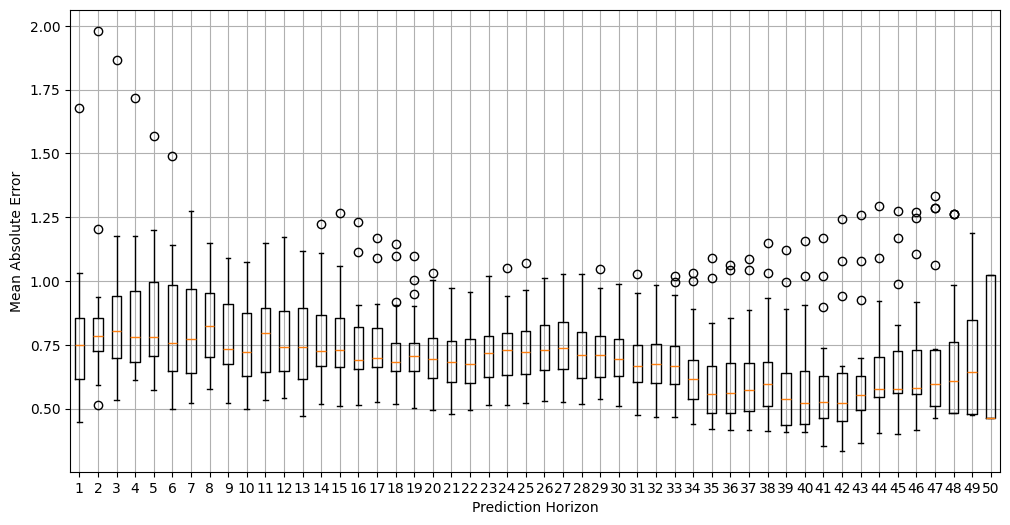

In [ ]:
from itertools import islice
import matplotlib.pyplot as plt

# Sélection des 50 premières clés
first_50_keys = list(islice(horiz_mae_list, 50))

# Création d'un nouveau dictionnaire avec seulement les 50 premières clés
first_50_dict = {key: horiz_mae_list[key] for key in first_50_keys}

# Création du boxplot
plt.figure(figsize=(12, 6))
plt.boxplot([first_50_dict[key] for key in first_50_dict], labels=first_50_dict.keys())
plt.title('') #Mean Absolute Error vs. Prediction Horizon
plt.xlabel('Prediction Horizon')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.show()

### MOyenne des MAE pour chaque horizon

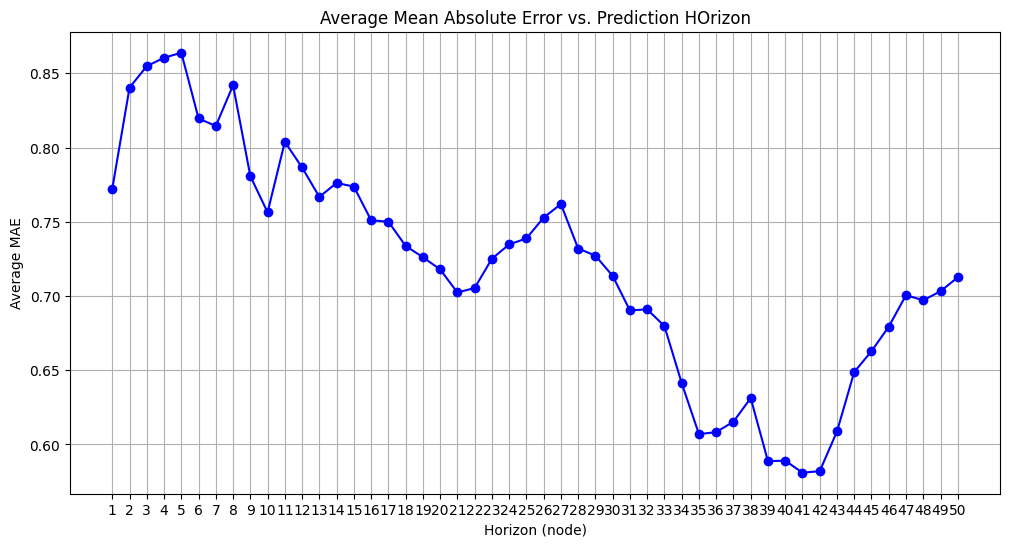

In [ ]:
# Calcul des moyennes pour chaque clé
means = {key: sum(values) / len(values) for key, values in first_50_dict.items()}

# Création du graphique en barres
plt.figure(figsize=(12, 6))
plt.plot(means.keys(), means.values(), marker = 'o',    linestyle='-', color='b')
plt.title("Average Mean Absolute Error vs. Prediction HOrizon")
plt.xlabel('Horizon (node)')
plt.ylabel('Average MAE')
plt.grid(True)
plt.show()

### Distribution des MAE tous horizons confondus

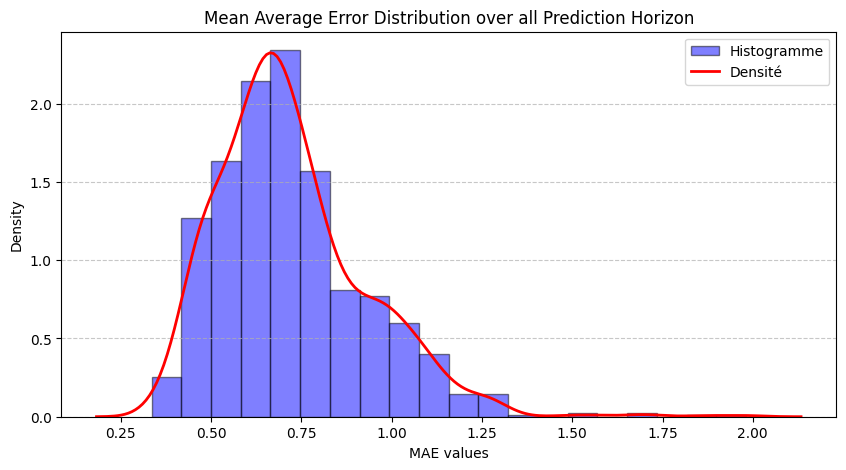

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Récupérer toutes les valeurs sous forme de liste unique
all_values = [value for values in first_50_dict.values() for value in values]

# Création de la figure
plt.figure(figsize=(10, 5))

# Histogramme normalisé (densité = True)
plt.hist(all_values, bins=20, density=True, color="blue", edgecolor="black", alpha=0.5, label="Histogramme")

# Ajout de la courbe de densité
sns.kdeplot(all_values, color="red", linewidth=2, label="Densité")

# Ajouter des labels et un titre
plt.xlabel("MAE values")
plt.ylabel("Density")
plt.title("Mean Average Error Distribution over all Prediction Horizon")

# Affichage de la légende
plt.legend()

# Affichage de la grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Montrer le graphique
plt.show()


In [ ]:
import pandas as pd

# Récupérer toutes les valeurs sous forme de liste unique
# Convertir la liste en une série pandas pour faciliter les calculs
data_series = pd.Series(all_values)

# Calculer les statistiques
mean = data_series.mean()
median = data_series.median()
quartiles = data_series.quantile([0.25, 0.5, 0.75])
std_dev = data_series.std()

# Afficher les résultats
print(f"Moyenne: {mean}")
print(f"Médiane: {median}")
print(f"Quartiles:\n{quartiles}")
print(f"Écart-type: {std_dev}")

Moyenne: 0.7200392585406971
Médiane: 0.6841418046720296
Quartiles:
0.25    0.578756
0.50    0.684142
0.75    0.820862
dtype: float64
Écart-type: 0.20636022704677873


# Graphiques pour visualiser la prédiction